# *Retail Data Warehouse Analytics Suite*

In [44]:
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import duckdb

In [45]:
# For customers table
customers = pd.read_csv(r"customers.csv")
customers['birthdate'] = pd.to_datetime(customers['birthdate'])
customers['create_date'] = pd.to_datetime(customers['create_date'])
customers.info()
customers.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_key     18484 non-null  int64         
 1   customer_id      18484 non-null  int64         
 2   customer_number  18484 non-null  object        
 3   first_name       18484 non-null  object        
 4   last_name        18484 non-null  object        
 5   country          18147 non-null  object        
 6   marital_status   18484 non-null  object        
 7   gender           18469 non-null  object        
 8   birthdate        18467 non-null  datetime64[ns]
 9   create_date      18484 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 1.4+ MB


,customer_key,customer_id,customer_number,first_name,last_name,country,marital_status,gender,birthdate,create_date
0,1,11000,AW00011000,Jon,Yang,Australia,Married,Male,1971-10-06,2025-10-06
1,2,11001,AW00011001,Eugene,Huang,Australia,Single,Male,1976-05-10,2025-10-06


In [46]:
# for product table
products = pd.read_csv(r"products.csv")
products['start_date'] = pd.to_datetime(products['start_date'])
products.info()
products.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   product_key     295 non-null    int64         
 1   product_id      295 non-null    int64         
 2   product_number  295 non-null    object        
 3   product_name    295 non-null    object        
 4   category_id     295 non-null    object        
 5   category        288 non-null    object        
 6   subcategory     288 non-null    object        
 7   maintenance     288 non-null    object        
 8   cost            295 non-null    int64         
 9   product_line    278 non-null    object        
 10  start_date      295 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 25.5+ KB


,product_key,product_id,product_number,product_name,category_id,category,subcategory,maintenance,cost,product_line,start_date
0,1,210,FR-R92B-58,HL Road Frame - Black- 58,CO_RF,Components,Road Frames,Yes,0,Road,2003-07-01


In [47]:
# for sales table
sales = pd.read_csv(r"sales.csv")
sales['order_date'] = pd.to_datetime(sales['order_date'])
sales['shipping_date'] = pd.to_datetime(sales['shipping_date'])
sales['due_date'] = pd.to_datetime(sales['due_date'])
sales.info()
sales.shape
sales.isnull().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_number   60398 non-null  object        
 1   product_key    60398 non-null  int64         
 2   customer_key   60398 non-null  int64         
 3   order_date     60379 non-null  datetime64[ns]
 4   shipping_date  60398 non-null  datetime64[ns]
 5   due_date       60398 non-null  datetime64[ns]
 6   sales_amount   60398 non-null  int64         
 7   quantity       60398 non-null  int64         
 8   price          60398 non-null  int64         
dtypes: datetime64[ns](3), int64(5), object(1)
memory usage: 4.1+ MB


np.int64(19)

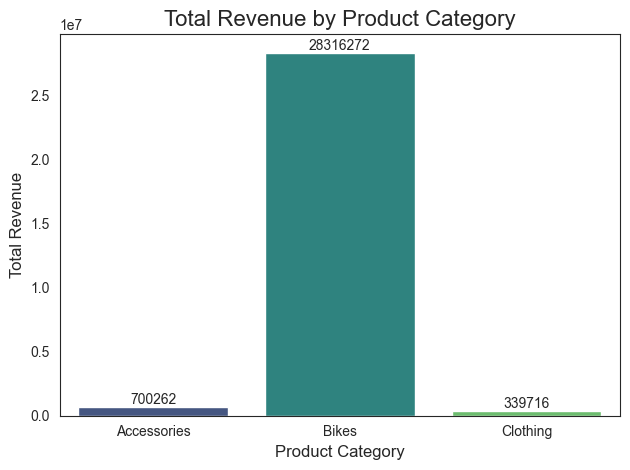

,category,total_revenue
0,Accessories,700262.0
1,Bikes,28316272.0
2,Clothing,339716.0


In [48]:
# What is the total revenue generated by each product category?

import duckdb 

query = """ 
    SELECT
        P.category,
        SUM(S.sales_amount) AS total_revenue
    FROM products AS P
    INNER JOIN sales AS S
    ON S.product_key = P.product_key
    GROUP BY 1
    ORDER BY 1 ASC
"""
cate_revenue = duckdb.query(query).df()

# For barplot

plt.Figure(figsize=(12,8))
sns.barplot(
    x="category",
    y="total_revenue",
    data=cate_revenue,
    palette="viridis"
)

for index, row in cate_revenue.iterrows():
    plt.text(
        index,
        row["total_revenue"],
        f'{row["total_revenue"]:.0f}',
        ha="center",
        va="bottom"
    )

plt.title("Total Revenue by Product Category", fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.tight_layout()
plt.show()

cate_revenue



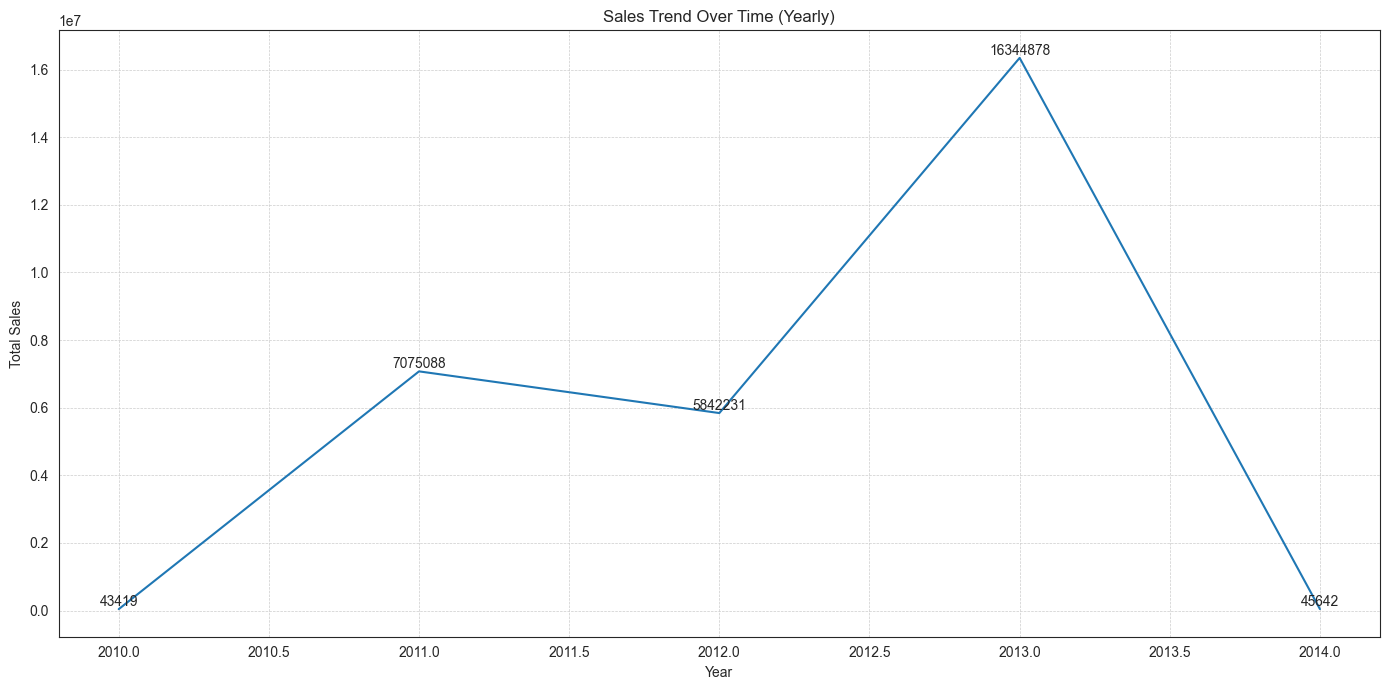

In [49]:
# How have sales trended over time (monthly or yearly)?

query = """
    SELECT
        EXTRACT(YEAR FROM order_date) AS orders_year,
        SUM(sales_amount) AS yearly_revenue
    FROM sales
    WHERE orders_year IS NOT NULL
    GROUP BY 1
    ORDER BY 1
"""
yearly_revenue = duckdb.query(query).df()

# For lineplot

plt.figure(figsize=(14,7))
sns.lineplot(
    x="orders_year",
    y="yearly_revenue",
    data=yearly_revenue,
    markers="o",
    linestyle="-"
)

for x, y in zip(yearly_revenue["orders_year"], yearly_revenue["yearly_revenue"]):
    plt.text(x, y, f"{y:.0f}", ha="center", va="bottom")

plt.title("Sales Trend Over Time (Yearly)")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


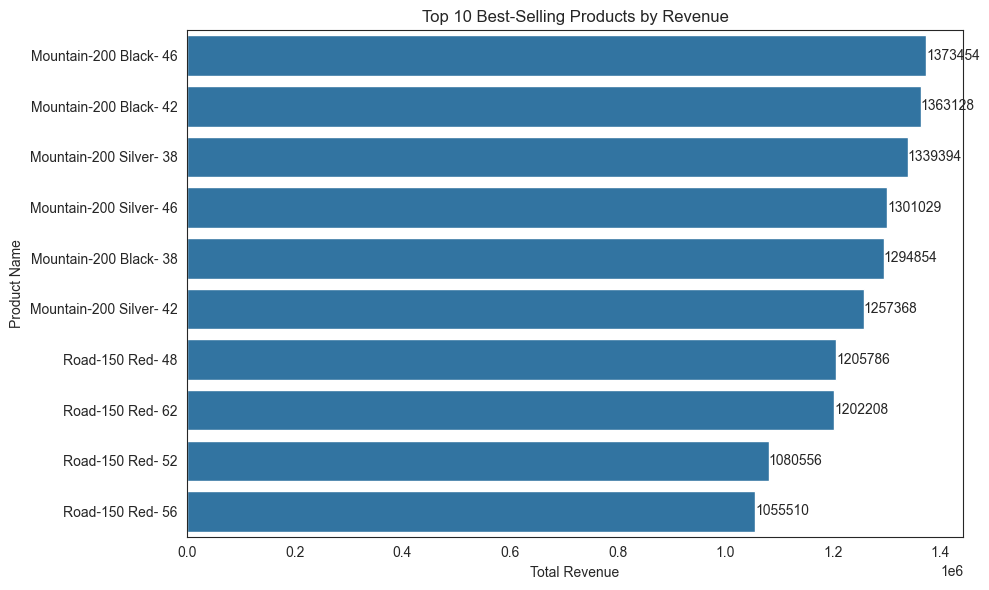

In [50]:
# Which are the top 10 best-selling products by revenue?

query = """
    SELECT
        product_name,
        total_revenue
    FROM(SELECT
            P.product_name,
            SUM(S.sales_amount) AS total_revenue,
            DENSE_RANK() OVER(ORDER BY SUM(S.sales_amount) DESC) AS rnk
        FROM products AS P
        INNER JOIN sales AS S
        ON S.product_key = P.product_key
        GROUP BY 1) AS X
    WHERE X.rnk <= 10
"""

product_10 = duckdb.query(query).df()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=product_10,
    x="total_revenue",
    y="product_name"
)
plt.title("Top 10 Best-Selling Products by Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Product Name")

for index, value in enumerate(product_10["total_revenue"]):
    plt.text(value, index, f"{value:.0f}", va="center")

plt.tight_layout()
plt.show()



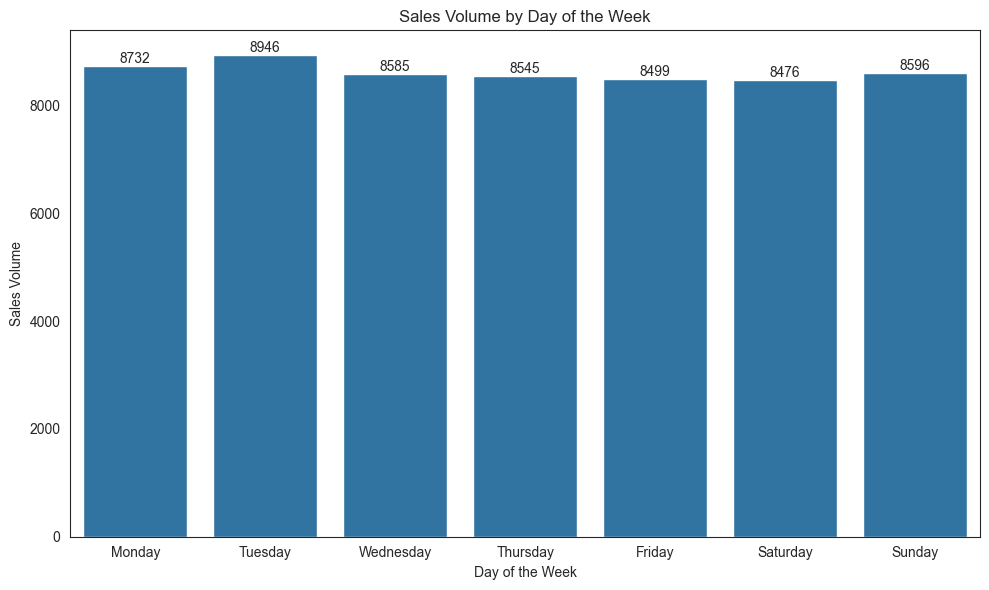

In [51]:
# How does sales volume vary by day of the week?

query = """
    SELECT
        EXTRACT(DOW FROM order_date) AS day_of_week,
        COUNT(order_number) AS sales_volume
    FROM sales
    WHERE day_of_week IS NOT NULL
    GROUP BY 1
    ORDER BY 1
"""
dow_sales =duckdb.query(query).df()

import pandas as pd

day_map = {
    0: "Sunday",
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday"
}
dow_sales['day_name'] = dow_sales['day_of_week'].map(day_map)

plt.figure(figsize=(10, 6))

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

sns.barplot(
    data=dow_sales,
    x="day_name",
    y="sales_volume",
    order=day_order
)

plt.title("Sales Volume by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Sales Volume")

for index, row in dow_sales.set_index("day_name").loc[day_order].reset_index().iterrows():
    plt.text(index, row["sales_volume"], f"{row['sales_volume']:.0f}",
             ha="center", va="bottom")

plt.tight_layout()
plt.show()


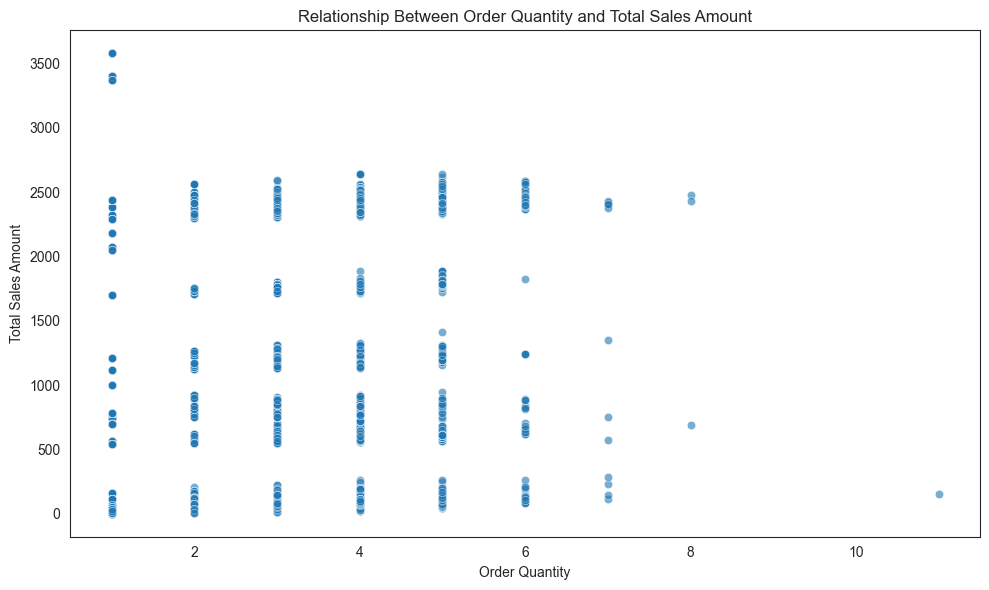

In [52]:
# What is the relationship between order quantity and total sales amount?

query = """
    SELECT
        order_number,
        SUM(quantity) AS order_quantity,
        SUM(sales_amount) AS order_sales
    FROM sales
    GROUP BY 1
"""
order_sales = duckdb.query(query).df()
order_sales

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=order_sales,
    x="order_quantity",
    y="order_sales",
    alpha=0.6
)

plt.title("Relationship Between Order Quantity and Total Sales Amount")
plt.xlabel("Order Quantity")
plt.ylabel("Total Sales Amount")
plt.tight_layout()
plt.show()


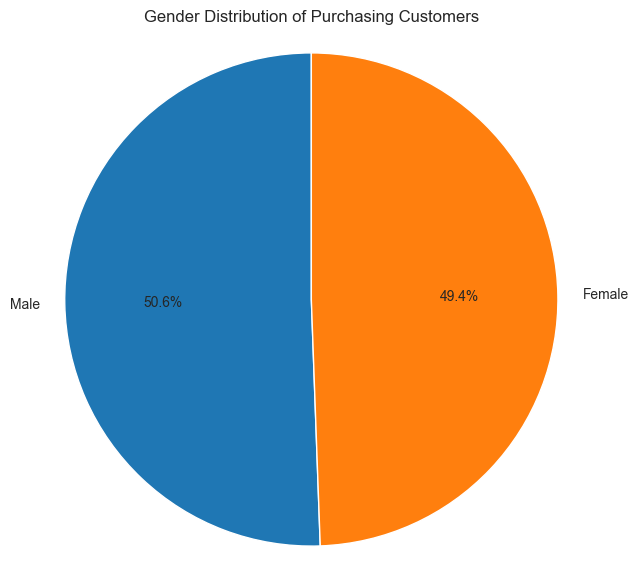

In [53]:
# What is the gender distribution of customers who made purchases?

query = """
    SELECT
        C.gender,
        COUNT(DISTINCT C.customer_key) AS customer_count
    FROM customers AS C
    INNER JOIN sales AS S
    ON C.customer_key = S.customer_key
    WHERE C.gender <> 'None'
    GROUP BY 1
"""
gender_dist = duckdb.query(query).df()
gender_dist

plt.figure(figsize=(7, 7))

plt.pie(
    gender_dist["customer_count"],
    labels=gender_dist["gender"],
    autopct="%1.1f%%",
    startangle=90
)

plt.title("Gender Distribution of Purchasing Customers")
plt.axis("equal")

plt.show()

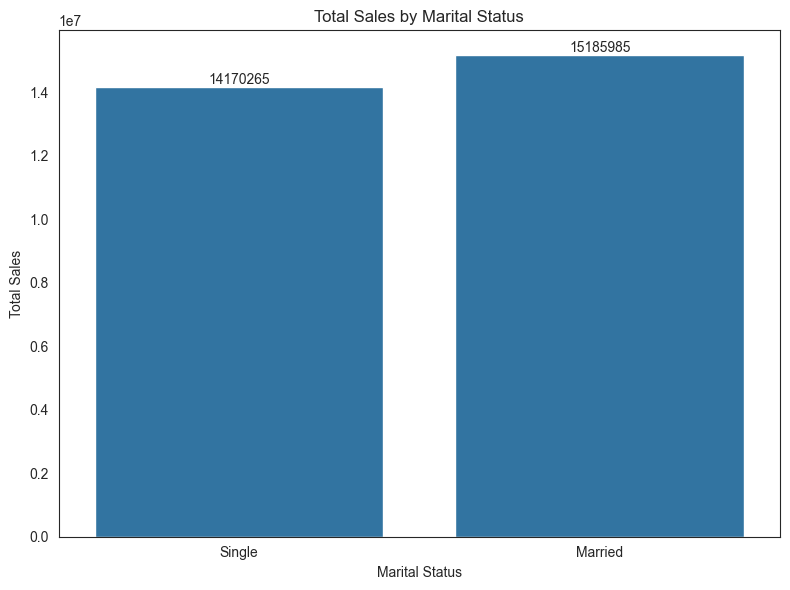

In [54]:
# How do sales compare between Married and Single customers?

query = """
    SELECT
        C.marital_status,
        SUM(S.sales_amount) AS total_sales
    FROM customers AS C
    INNER JOIN sales AS S
    ON C.customer_key = S.customer_key
    GROUP BY 1
"""
marital_sales = duckdb.query(query).df()
marital_sales

marital_sales.columns = marital_sales.columns.str.strip().str.lower()

plt.figure(figsize=(8, 6))

sns.barplot(
    data=marital_sales,
    x="marital_status",
    y="total_sales"
)

plt.title("Total Sales by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Total Sales")

for index, row in marital_sales.iterrows():
    plt.text(index, row["total_sales"], f"{row['total_sales']:.0f}",
             ha="center", va="bottom")

plt.tight_layout()
plt.show()

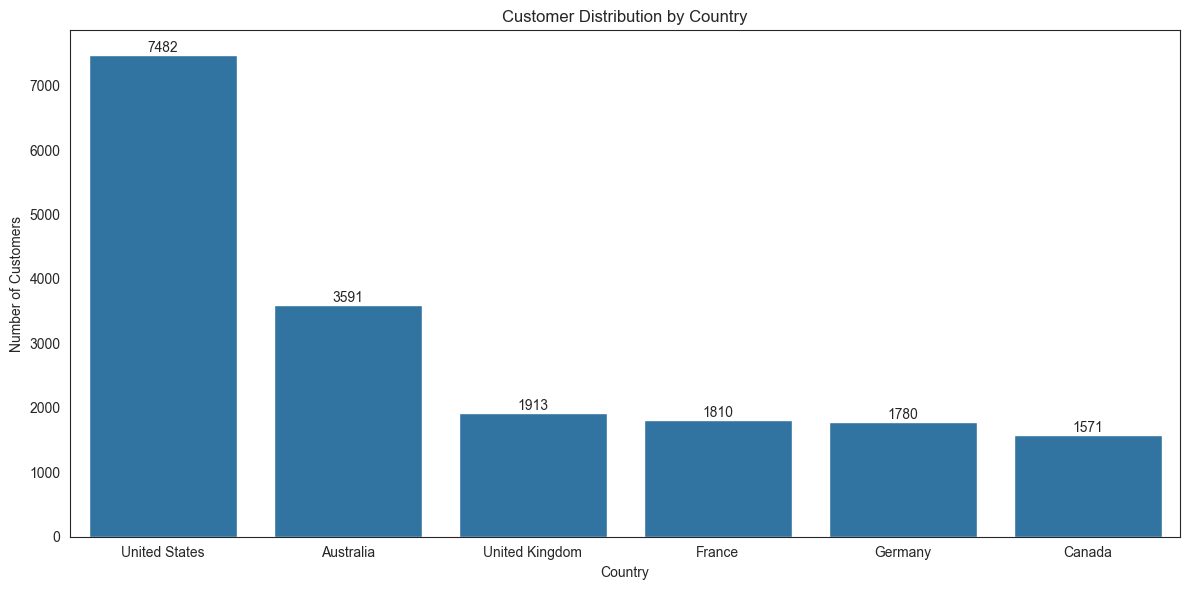

,country,customer_count
0,United States,7482
1,Australia,3591
2,United Kingdom,1913
3,France,1810
4,Germany,1780
5,Canada,1571


In [55]:
# What is the distribution of customers by country?

query = """
    SELECT
        C.country,
        COUNT(DISTINCT C.customer_key) AS customer_count
    FROM customers AS C
    INNER JOIN sales AS S
    ON C.customer_key = S.customer_key
    WHERE C.country IS NOT NULL
    GROUP BY 1
    ORDER BY 2 DESC
"""
country_dist = duckdb.query(query).df()
country_dist

plt.figure(figsize=(12, 6))

sns.barplot(
    data=country_dist,
    x="country",
    y="customer_count"
)

plt.title("Customer Distribution by Country")
plt.xlabel("Country")
plt.ylabel("Number of Customers")

for index, row in country_dist.iterrows():
    plt.text(
        index,
        row["customer_count"],
        f"{row['customer_count']}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

country_dist



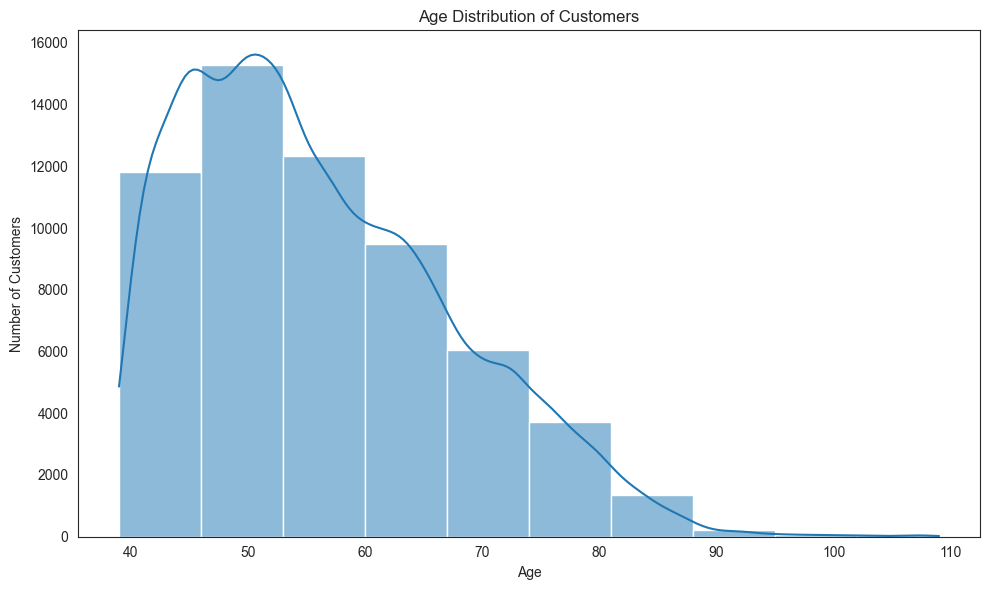

In [56]:
# What is the age distribution of the customers?

query = """
    SELECT
        C.customer_key,
        EXTRACT(YEAR FROM AGE(C.birthdate)) AS age
    FROM customers AS C
    INNER JOIN sales AS S
    ON C.customer_key = S.customer_key
    WHERE C.birthdate IS NOT NULL
"""
age_dist = duckdb.query(query).df()
age_dist

plt.figure(figsize=(10, 6))

sns.histplot(
    data=age_dist,
    x="age",
    bins=10,
    kde=True
)
plt.title("Age Distribution of Customers")
plt.xlabel("Age")
plt.ylabel("Number of Customers")

plt.tight_layout()
plt.show()


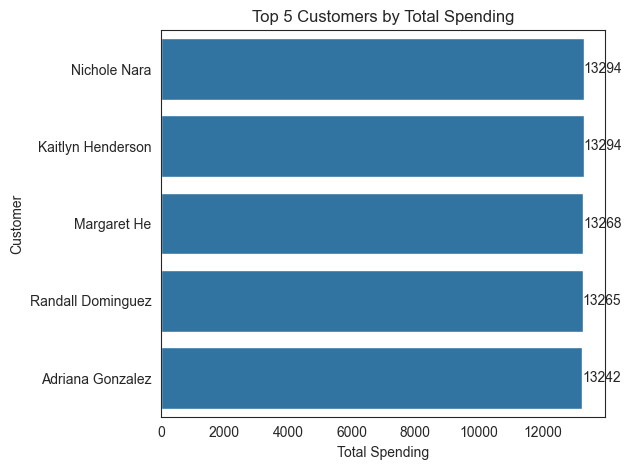

,customer_key,customername,total_spent
0,1302,Nichole Nara,13294.0
1,1133,Kaitlyn Henderson,13294.0
2,1309,Margaret He,13268.0
3,1132,Randall Dominguez,13265.0
4,1301,Adriana Gonzalez,13242.0


In [57]:
# Who are the top 5 customers based on total spending?

query = """
    SELECT
        C.customer_key,
        CONCAT(C.first_name,' ',C.last_name) AS customername,
        SUM(S.sales_amount) AS total_spent
    FROM customers AS C
    INNER JOIN sales AS S
    ON C.customer_key = S.customer_key
    GROUP BY 1, 2
    ORDER BY 3 DESC
    LIMIT 5
"""
top_customers = duckdb.query(query).df()

sns.barplot(
    data=top_customers,
    x="total_spent",
    y="customername"
)

plt.title("Top 5 Customers by Total Spending")
plt.xlabel("Total Spending")
plt.ylabel("Customer")

for index, value in enumerate(top_customers["total_spent"]):
    plt.text(value, index, f"{value:.0f}", va="center")

plt.tight_layout()
plt.show()

top_customers

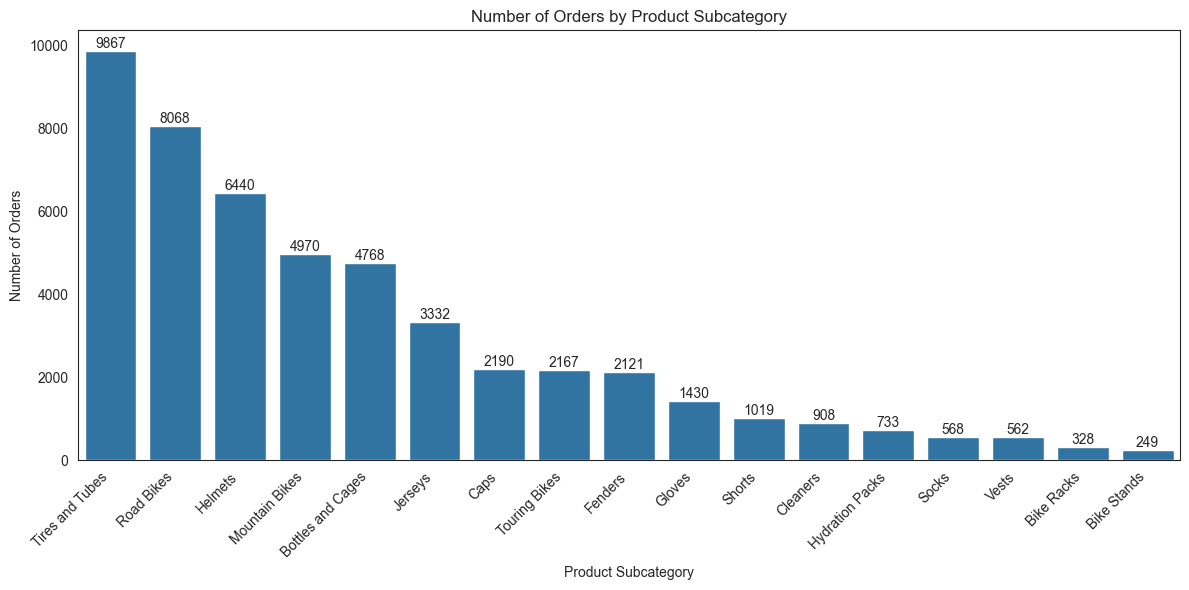

,subcategory,order_count
0,Tires and Tubes,9867
1,Road Bikes,8068
2,Helmets,6440
3,Mountain Bikes,4970
4,Bottles and Cages,4768
5,Jerseys,3332
6,Caps,2190
7,Touring Bikes,2167
8,Fenders,2121
9,Gloves,1430


In [58]:
# Which product subcategory has the highest number of orders?

query = """
    SELECT
        P.subcategory,
        COUNT(DISTINCT S.order_number) AS order_count
    FROM products AS P
    INNER JOIN sales AS S
    ON S.product_key = P.product_key
    GROUP BY 1
    ORDER BY 2 DESC
"""
subcategory_orders = duckdb.query(query).df()
subcategory_orders

plt.figure(figsize=(12, 6))

sns.barplot(
    data=subcategory_orders,
    x="subcategory",
    y="order_count"
)

plt.title("Number of Orders by Product Subcategory")
plt.xlabel("Product Subcategory")
plt.ylabel("Number of Orders")

plt.xticks(rotation=45, ha="right")

for index, row in subcategory_orders.iterrows():
    plt.text(
        index,
        row["order_count"],
        f"{row['order_count']}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

subcategory_orders

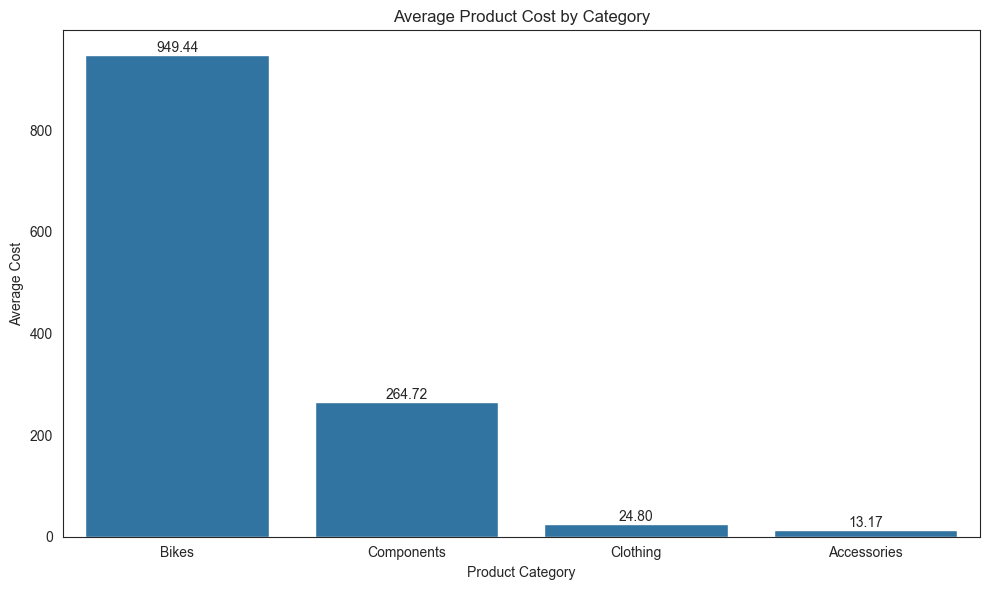

,category,avg_cost
0,Bikes,949.443299
1,Components,264.716535
2,Clothing,24.800000
3,Accessories,13.172414


In [59]:
# How does the average product cost compare across different categories?

query = """
    SELECT
        category,
        AVG(cost) AS avg_cost
    FROM products
    WHERE category IS NOT NULL
    GROUP BY category
    ORDER BY avg_cost DESC;
"""
category_price = duckdb.query(query).df()

plt.figure(figsize=(10, 6))

sns.barplot(
    data=category_price,
    x="category",
    y=category_price.columns[1]
)

plt.title("Average Product Cost by Category")
plt.xlabel("Product Category")
plt.ylabel("Average Cost")

for index, row in category_price.iterrows():
    plt.text(
        index,
        row[1],
        f"{row[1]:.2f}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


category_price


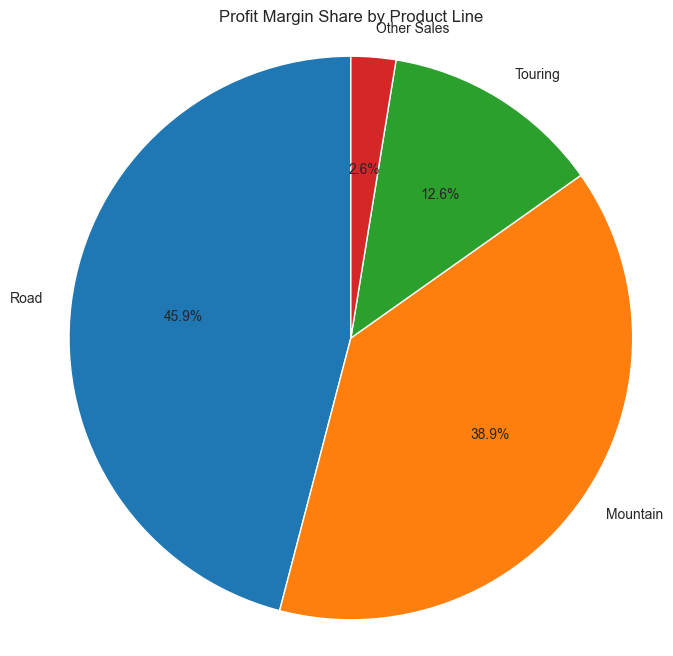

,product_line,total_profit
0,Road,5367577.0
1,Mountain,4541871.0
2,Touring,1476164.0
3,Other Sales,300145.0


In [60]:
# What is the profit margin share by Product Line (e.g., Road, Mountain)?

query = """
    SELECT
        P.product_line,
        SUM(S.sales_amount) - SUM(S.quantity * P.cost) AS total_profit
    FROM sales AS S
    INNER JOIN products AS P
    ON P.product_key = S.product_key
    GROUP BY 1
    ORDER BY 2 DESC
"""
profit_by_line = duckdb.query(query).df()

sns.set_style("white")

plt.figure(figsize=(8, 8))

plt.pie(
    profit_by_line["total_profit"],
    labels=profit_by_line["product_line"],
    autopct="%1.1f%%",
    startangle=90
)

plt.title("Profit Margin Share by Product Line")
plt.axis("equal")

plt.show()

profit_by_line

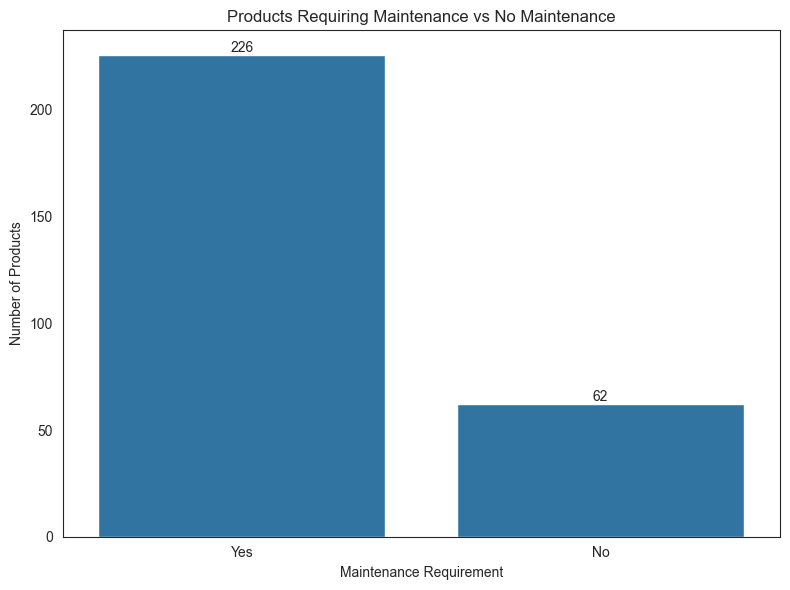

,maintenance,product_count
0,Yes,226
1,No,62


In [61]:
products.head(2)

# How many products require maintenance vs. those that don't?

query = """
    SELECT
        maintenance,
        COUNT(DISTINCT product_id) AS product_count
    FROM products
    WHERE maintenance IS NOT NULL
    GROUP BY 1

"""
maintenance_dist = duckdb.query(query).df()

plt.figure(figsize=(8, 6))

sns.barplot(
    data=maintenance_dist,
    x="maintenance",
    y="product_count"
)

plt.title("Products Requiring Maintenance vs No Maintenance")
plt.xlabel("Maintenance Requirement")
plt.ylabel("Number of Products")
for index, row in maintenance_dist.iterrows():
    plt.text(
        index,
        row["product_count"],
        f"{row['product_count']}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

maintenance_dist

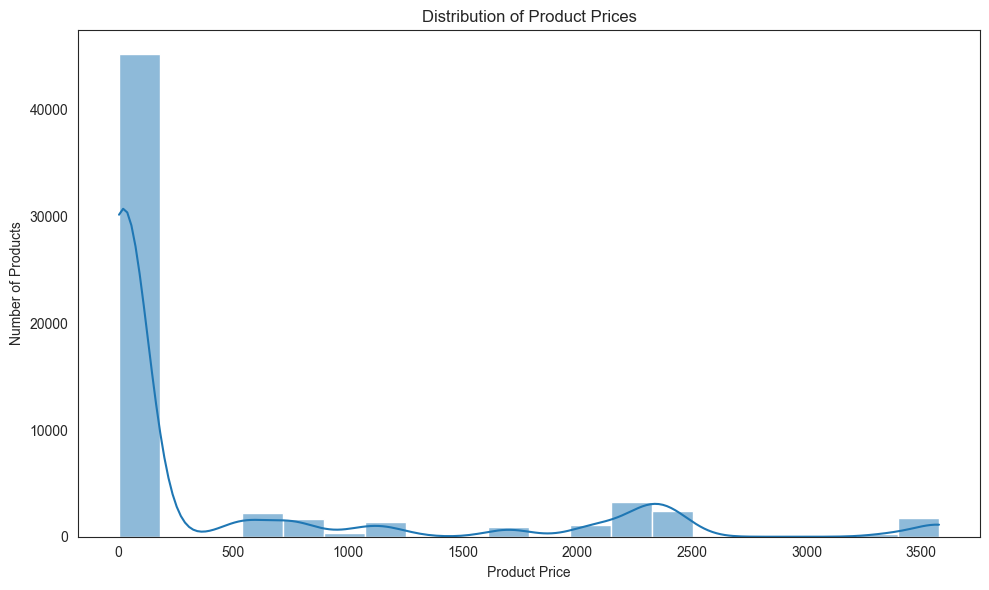

In [62]:
# What is the distribution of product prices?

query = """
    SELECT
        S.price
    FROM sales AS S
    INNER JOIN products AS P
    ON P.product_key = S.product_key
    WHERE S.price IS NOT NULL
"""
price_dist = duckdb.query(query).df()

plt.figure(figsize=(10, 6))

sns.histplot(
    data=price_dist,
    x="price",
    bins=20,
    kde=True
)

plt.title("Distribution of Product Prices")
plt.xlabel("Product Price")
plt.ylabel("Number of Products")

plt.tight_layout()
plt.show()

In [63]:
products.head(1)
customers.head(1)
sales.head(1)

,order_number,product_key,customer_key,order_date,shipping_date,due_date,sales_amount,quantity,price
0,SO54496,282,5400,2013-03-16,2013-03-23,2013-03-28,25,1,25
